Use Cyber-ZHG's various Keras tools for NLP: Attention, Multi-head, etc.

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')
#!pip install numpy==1.16.1
!pip install keras==2.2.4
!wget -nc https://raw.githubusercontent.com/LanceNorskog/deep_meter_2/master/haiku_5.txt
!cut -f2 < haiku_5.txt | sort | uniq > haiku_5_short.txt
!wc -l haiku_5*.txt

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
File ‘haiku_5.txt’ already there; not retrieving.

   95631 haiku_5_short.txt
  673680 haiku_5.txt
  769311 total


In [2]:
!pip uninstall -qy git+https://github.com/LanceNorskog/deep_meter_2#egg=deepmeter
!pip install -q git+https://github.com/LanceNorskog/deep_meter_2#egg=deepmeter


In [3]:

from __future__ import print_function
import math
import pickle
import json
import os
import glob
import time

import numpy as np
import tensorflow as tf
import keras.backend as K
import matplotlib.pyplot as plt

from keras.preprocessing import sequence
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import Model, Sequential, load_model
from keras import layers 
from keras import metrics
from keras.preprocessing import text
from sklearn.model_selection import train_test_split

from cmu.syllables_cmu import syllables as word2sylls
from cmu.mappers import Decoder, trim_homynyms
from search.full import FullSearch
from cmu.topk import topk as get_top_k
from cmu.wordmap import Wordmap
from cmu.readhaiku import Reader

#from cmu.report import find_top_k_match, report
from keras_stuff.loss import sparse_categorical_crossentropy as scc
#from keras_stuff.loss import sparse_categorical_crossentropy_temporal as scct
import keras_stuff.metrics as my_metrics

print(word2sylls['therefore'])

# number of total samples to use
max_data = 1000000
# number of words for hashing trick
hash_mole = 20000
# number of output syllables in short haiku
max_features = 16000
# longest output sentence
max_len = 5
# longest input sentence
max_words = 12
# what you think
batch_size = 32
# do not output the same haiku twice
deduplicate_haiku=False
# emit output as input
duplicate_haiku=True
# use long as input
use_big_text=False

model_base="/content/gdrive/My Drive/Colab Notebooks/haiku_zhg_5"
model_file=model_base + ".h5".format(int(time.time()))
print(model_file)


Using TensorFlow backend.


['DH EH R', 'F AO R']
/content/gdrive/My Drive/Colab Notebooks/haiku_zhg_5.h5


In [4]:
!date
print(word2sylls['door'])
#word2sylls = trim_homynyms(word2sylls)
print(word2sylls['door'])
decoder = Decoder(word2sylls)
syll2idx = decoder.syll2idx
idx2syll = decoder.idx2syll
num_sylls = len(idx2syll)

print(syll2idx['DH EH R'], idx2syll[1])
print('# features: ', len(idx2syll))

for i in range(decoder.wordoff):
    decoder.wordlist[i] = 'word{}'.format(i)
    decoder.wordlength[i] = 1
for i in range(decoder.sylloff):
    decoder.idx2syll[i] = 'syll{}'.format(i)

big_haiku_file = "haiku_5.txt"
wordmap = Wordmap(len(decoder.wordlist))
reader = Reader(word2sylls, decoder, wordmap)
(big_text, big_haiku, big_data) = reader.readfile(big_haiku_file, max_words=max_words, 
    deduplicate_haiku=deduplicate_haiku, duplicate_haiku=duplicate_haiku, max_data=max_data)
big_hash = reader.gethash(big_text, max_words=max_words, hash_mole=hash_mole)
haikuwordset = reader.haikuwordset
print('{} -> {} : {}'.format(big_text[0], big_haiku[0], big_data[0]))

print('Full length clauses: ', len(big_text))
print('Wordmap total entries: ', wordmap.count())
print('Wordmap length: ', wordmap.length())

Sun Jul 28 09:13:34 UTC 2019
['D AO R']
['D AO R']
2443 0
# features:  15098
a white sink and door -> a white sink and door : [[  156]
 [14238]
 [10115]
 [  125]
 [ 1844]]
Full length clauses:  1000001
Wordmap total entries:  63933
Wordmap length:  229463


In [5]:
# Split multiple datasets
(train_i, test_i, _, _) = train_test_split(np.arange(len(big_data)), np.arange(len(big_data)))

train_len=(len(train_i)//batch_size) * batch_size
test_len=(len(test_i)//batch_size) * batch_size
x_train = big_hash[train_i][:train_len]
y_train = big_data[train_i][:train_len]
x_test = big_hash[test_i][-test_len:]
y_test = big_data[test_i][-test_len:]

print(big_text[train_i[0]], x_test[0], str(y_test[0]))

def get_lstm(size, return_sequences=True):
    #return layers.LSTM(size, return_sequences=return_sequences)
    return layers.CuDNNLSTM(size, return_sequences=return_sequences)

#x_train = np.array(x_train)
#x_test = np.array(x_test)
#y_train = np.expand_dims(y_train, -1)
#y_test = np.expand_dims(y_test, -1)
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)
print(y_test[0][0])



various items [10339. 16579.  9471. 16747. 19320.     0.     0.     0.     0.     0.
     0.     0.] [[  156]
 [  829]
 [  125]
 [14238]
 [ 1828]]
x_train shape: (749984, 12)
x_test shape: (249984, 12)
y_train shape: (749984, 5, 1)
y_test shape: (249984, 5, 1)
[156]


In [6]:


embed_size=512
units_k=embed_size
units_v=embed_size
units_v=embed_size//3
units=512
dropout=0.5

metric_list = [my_metrics.sparse, my_metrics.perfect]
metric_names = ['sparse', 'perfect']

hash_input = layers.Input(shape=(max_words,), dtype='int32')
x = layers.Embedding(hash_mole, embed_size, input_length=max_words)(hash_input)
x = layers.Dropout(dropout)(x)
x = layers.Bidirectional(get_lstm(units//2, return_sequences=False))(x)
x = layers.RepeatVector(max_len)(x)
x = get_lstm(units, return_sequences=True)(x)
x = layers.Dropout(dropout)(x)
output_layer = layers.Dense(max_features, activation='softmax')(x)


model = Model(inputs=[hash_input], outputs=output_layer)
model.compile('adam', 'sparse_categorical_crossentropy', metrics=metric_list)
model.summary()

# try using different optimizers and different optimizer configs

print('Train...')
history = None
use_saved_model=False
if not use_saved_model or not os.path.exists(model_file):
  with tf.Session() as session:
    K.manual_variable_initialization(False)
    model_file=model_base + ".h5".format(int(time.time()))
    K.set_session(session)
    session.run(tf.global_variables_initializer())
    session.run(tf.tables_initializer())

    history = model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=300,
          callbacks=[EarlyStopping(monitor='val_perfect', mode='max', verbose=1, patience=10),
            ModelCheckpoint(model_file, monitor='val_perfect', save_best_only=True, save_weights_only=True, mode='max', verbose=1)],
          verbose=2,
          validation_data=[x_test, y_test])


W0728 09:14:05.448691 140656913483648 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0728 09:14:05.469217 140656913483648 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0728 09:14:05.472628 140656913483648 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0728 09:14:05.484499 140656913483648 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0728 09:14:05.493386 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 12)                0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 12, 512)           10240000  
_________________________________________________________________
dropout_1 (Dropout)          (None, 12, 512)           0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 512)               1576960   
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 5, 512)            0         
_________________________________________________________________
cu_dnnlstm_2 (CuDNNLSTM)     (None, 5, 512)            2101248   
_________________________________________________________________
dropout_2 (Dropout)          (None, 5, 512)            0         
__________

W0728 09:14:08.898014 140656913483648 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 749984 samples, validate on 249984 samples
Epoch 1/300
 - 734s - loss: 1.4690 - sparse: 0.7399 - perfect: 0.4966 - val_loss: 0.4175 - val_sparse: 0.9248 - val_perfect: 0.8154

Epoch 00001: val_perfect improved from -inf to 0.81541, saving model to /content/gdrive/My Drive/Colab Notebooks/haiku_zhg_5.h5
Epoch 2/300
 - 730s - loss: 0.4701 - sparse: 0.9070 - perfect: 0.7567 - val_loss: 0.2698 - val_sparse: 0.9517 - val_perfect: 0.8831

Epoch 00002: val_perfect improved from 0.81541 to 0.88315, saving model to /content/gdrive/My Drive/Colab Notebooks/haiku_zhg_5.h5
Epoch 3/300
 - 730s - loss: 0.3590 - sparse: 0.9269 - perfect: 0.8015 - val_loss: 0.2278 - val_sparse: 0.9595 - val_perfect: 0.9041

Epoch 00003: val_perfect improved from 0.88315 to 0.90410, saving model to /content/gdrive/My Drive/Colab Notebooks/haiku_zhg_5.h5
Epoch 4/300
 - 730s - loss: 0.3163 - sparse: 0.9344 - perfect: 0.8184 - val_loss: 0.2057 - val_sparse: 0.9638 - val_perfect: 0.9162

Epoch 00004: val_perfect i

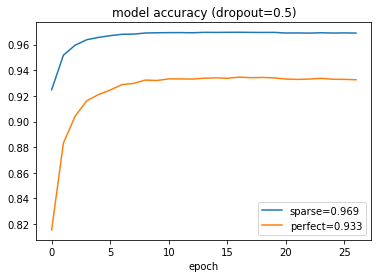

In [7]:

plt.figure()
if history != None:
  # summarize history for accuracy
  for m in metric_names:
      #plt.plot(history.history[m])
      plt.plot(history.history['val_' + m])
  plt.title('model accuracy (dropout={})'.format(dropout))
  plt.xlabel('epoch')
  sname = []
  for m in metric_names:
      sname.append('{}={:01.3f}'.format(m, history.history['val_' + m][-1]))
  plt.legend(sname, loc='lower right')
  plt.show()

In [8]:
with tf.Session() as session:
  K.set_session(session)
  session.run(tf.global_variables_initializer())
  session.run(tf.tables_initializer())
  model.load_weights(model_file)  
  eval_small = model.evaluate(x_test, y_test)
  print('model.evaluate on test data: ' ,model.metrics_names, eval_small)
  print('history: ', history)


   416/249984 [..............................] - ETA: 2:45

Exception ignored in: <bound method BaseSession._Callable.__del__ of <tensorflow.python.client.session.BaseSession._Callable object at 0x7fecdfe01a90>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/client/session.py", line 1473, in __del__
    self._session._session, self._handle)
tensorflow.python.framework.errors_impl.CancelledError: (None, None, 'Session has been closed.')


249984/249984 [==============================] - 55s 220us/step
model.evaluate on test data:  ['loss', 'sparse', 'perfect'] [0.17776662190795564, 0.9696684572569114, 0.9346358166922683]
history:  <keras.callbacks.History object at 0x7fece31aae48>


In [0]:
def find_top_k_match(data, prediction, top_k=5):
        out = [-1] * len(data)
        for i in range(len(data)):
            topind = np.argsort(prediction[i])
            topind = topind[-top_k:]
            for j in range(top_k):
                #print(data[i][0], topind[j])
                if data[i][0] == topind[j]:
                    out[i] = topind[j]
        return out
    
def report(data, prediction):
    def match(data, prediction):
        assert len(data.shape) == 2
        assert len(prediction.shape) == 2
        good = 0
        top5 = 0
        count = 0
        for i in range(len(data)):
            topind = np.argsort(prediction[i])
            if data[i][0] == topind[-1]:
                good += 1
            topind = topind[-5:len(topind)]
            for j in range(5):
                if data[i][0] == topind[j]:
                    top5 += 1
                    break
            count += 1
        return (good, top5, count)

    _sparse = 0.0
    _perfect = 0.0
    _sparse5 = 0.0
    _perfect5 = 0.0
    _total = 0
    for n in range(len(data)):
        #print(len(short[n]))
        (good, top5, count) = match(data[n], predicts[n])
        if count == 0:
            continue
        _sparse += good/count
        _sparse5 += top5/count
        if good == count:
            _perfect += 1  
        if top5 == count:
            _perfect5 += 1
        _total += 1
    return {'sparse':_sparse/_total, 'perfect': _perfect/_total, 'sparse5': _sparse5/_total, 'perfect5': _perfect5/_total}


In [0]:
top_k=5

fs = FullSearch(top_k * top_k * top_k, 5, top_k)
def decodem(predict, top_k):
    global fs
    (top_vals, top_paths) = get_top_k(np.array([predict]), top_k=top_k)
    #print('top_paths: ' + str(top_paths))
    #print(top_paths.shape)
    fs.mainloop(top_paths[0])
    #print('score[0]: {}'.format(fs.scorevals[0]))
    #print('paths[0]: {}'.format(fs.scorepaths[0]))
    #print('score[-1]: {}'.format(fs.scorevals[-1]))
    #print('paths[-1]: {}'.format(fs.scorepaths[-1]))
    #print('min {}, max {}'.format(np.min(fs.scorevals), np.max(fs.scorevals)))
    morepaths = np.zeros(fs.scorepaths.shape, dtype='int32')
    for j in range(fs.scorepaths.shape[0]):
        #print('scorepaths[{}]: {}'.format(j, fs.scorepaths[j]))
        #print('predict.shape: ', predict.shape)
        #print('top_paths.shape: ', top_paths.shape)
        #print('top_paths[{}]: {}'.format(j, top_paths))
        #print('top_paths[{}][]: {}'.format(j, top_paths[0][np.arange(max_len), fs.scorepaths[j]]))
        morepaths[j] = top_paths[0][np.arange(max_len), fs.scorepaths[j]]
    #print('morepaths: ' + str(morepaths))
    encoded = decoder.get_sentences(morepaths)
    sentences = {}
    if len(encoded) > 0:
        #print(encoded)
        decoded = []
        for e1 in encoded:
            if len(e1) > 0 and len(e1[0]) > 0:
                dec = decoder.decode_sentences([e1])
                decoded.append(dec)
        for d1 in decoded:
            for d2 in d1:
                for d3 in d2:
                    for d4 in d3:
                        go = True
                        _lastidx = -1
                        for w in d4:
                            if not w in haikuwordset:
                                go = False
                            _idx = decoder.word2idx[w]
                            if _lastidx > 0:
                                if _lastidx == _idx or not wordmap.get(_lastidx, _idx):
                                    go = False
                                    #print('Fail: {},{} {},{}'.format(_lastidx, _idx, _lastword, w))
                            _lastidx = _idx
                            _lastword = w
                        if go:
                            key = ' '.join(d4)
                            sentences[key] = d4
                    #print('d3: ', d3)
                    #key = ' '.join(d3)
                    #sentences[key] = d3
    return sentences

# return N possible sentences with the fewest words
def short_sentences(sentences):
    out = {}
    for i in range(1, max_len + 1):
        for (k, v) in sentences.items():
            if len(v) == i:
                out[k] = v
        if len(out) > 4:
            return out
    return out

In [0]:
   
bigbatch = batch_size * 32
with tf.Session() as session:
  K.set_session(session)
  session.run(tf.global_variables_initializer())
  session.run(tf.tables_initializer())
  model.load_weights(model_file)  
  biglen = len(x_test)
  for i in range(0, biglen, bigbatch):
      predicts = model.predict(x_train[i:i + bigbatch], batch_size=bigbatch)
      for j in range(0, len(predicts)):
          #f = find_top_k_match(y_test[i + j], predicts[j], 5)
          #if np.min(f) > 0 and j == 0:
          #    print('{} -> {}'.format(x_test[i + j], [decoder.idx2syll[k] for k in f]))
          sentences = decodem(predicts[j], 5)
          if len(sentences) > 0:
              for s in short_sentences(sentences):
                    print('{} -> {}'.format(big_text[train_i][i + j], s))
              #print('{} -> {}'.format(x_test[i + j], sentences[0]))
              #for k in range(1, len(sentences)):
              #      print('. -> {}'.format(sentences[k]))
    

a lot of planes parked in the airport -> ar tutu win plains
a lot of planes parked in the airport -> ar tutu win plane's
a lot of planes parked in the airport -> ar tutu win planes
a lot of planes parked in the airport -> r tutu win plains
a lot of planes parked in the airport -> r tutu win plane's
a lot of planes parked in the airport -> r tutu win planes
a lot of planes parked in the airport -> ar tutu win plain
a lot of planes parked in the airport -> ar tutu win plane
a lot of planes parked in the airport -> r tutu win plain
a lot of planes parked in the airport -> r tutu win plane
a lot of planes parked in the airport -> ar tutu win port
a lot of planes parked in the airport -> r tutu win port
a lot of planes parked in the airport -> stopped to two airplanes
a lot of planes parked in the airport -> stopped to two airport
in a restaurant -> with two restaurant
to the camera -> tutu canopy
to the camera -> tutu carry the
to the camera -> tutu carry a
a large open room has an overhea

In [1]:

(mini_vals, mini_preds) = get_top_k(np.array(predicts), top_k=top_k)
#print('top preds: ', mini_preds[0])
#print(mini_preds.shape)
total = 0
_go = []
for x in mini_preds[0]:
            _go.append(decoder.idx2syll[x[0]])
print('{} -> {}'.format(x_short[0], str(_go)))
for i in range(len(mini_preds)):
    fs = FullSearch(top_k * top_k * top_k, 5, top_k)
    fs.mainloop(mini_preds[i])
    #print('score[0]: {}'.format(fs.scorevals[0]))
    #print('paths[0]: {}'.format(fs.scorepaths[0]))
    #print('score[-1]: {}'.format(fs.scorevals[-1]))
    #print('paths[-1]: {}'.format(fs.scorepaths[-1]))
    #print('min {}, max {}'.format(np.min(fs.scorevals), np.max(fs.scorevals)))
    print('{} -> {}'.format(x_short[i], [decoder.idx2syll[x] for x in fs.scorepaths[0]]))
    morepaths = np.zeros(fs.scorepaths.shape, dtype='int32')
    print(mini_preds[i].shape)
    print(morepaths.shape)
    for j in range(fs.scorepaths.shape[0]):
        #print(fs.scorepaths[j])
        #z = mini_preds[i][np.arange(max_len), fs.scorepaths[j]]
        #print(z)
        morepaths[j] = mini_preds[i][np.arange(max_len), fs.scorepaths[j]]
    #print(morepaths[0])
    encoded = decoder.get_sentences(morepaths)
    if i == 0:
        print('encoded[0]: ', encoded[0])
    #d = []
    # for x in encoded:
    #   for y in x:
    #        if len(y) > 0:
    #           d.append(y[0])  
    #d = np.array(d)
    d = encoded
    if len(d) > 0:
        print('encoded sentences: ', d)
        print(x_short[i], ':')
        #print(mini_preds[0])
        total += 1
        decoded = decoder.decode_sentences(encoded)
        #print('len(decoded): ', len(decoded))
        ##print('len(decoded[0]): ', len(decoded[0]))
        #print('len(decoded[0][0]): ', len(decoded[0][0]))
        #print('len(decoded[0][0][0]): ', len(decoded[0][0][0]))
        #print('decoded[0][0][0]: ', decoded[0][0][0])
        sentences = {}
        for d1 in decoded:
            for d2 in d1:
                for d3 in d2:
                    print('d3: ', d3)
                    break
                    key = ' '.join(d3)
                    sentences[key] = d3
                    break
                     
        print('[{}]  -> {}', i,list(sentences.keys())[0:10])
    break
print('Total decoded: {}'.format(total))

NameError: ignored

In [2]:
with tf.Session() as session:
  #K.manual_variable_initialization(True)  
  K.set_session(session)
  session.run(tf.global_variables_initializer())
  session.run(tf.tables_initializer())
  #model = load_model(model_file)  
  model.load_weights(model_file)  
  eval_small = model.evaluate(test_x, test_y)
  print('model.evaluate on haiku clauses: ' ,model.metrics_names, eval_small)
  print('history: ', history)
  eval_big = model.evaluate(big_text, big_data)
  print('model.evaluate on long clauses: ' ,model.metrics_names, eval_big)
  print('history: ', history)
  biglen = len(big_text)
  #for i in range(0, len(big_text), batch_size):
  #  predicts = model.predict(big_text[i:i + batch_size], batch_size=batch_size)
  #  print('shape: {}'.format(predicts.shape))


NameError: ignored

In [3]:
metric_list = [sparse, perfect, sparse5, perfect5]
metric_names = ['sparse', 'perfect', 'sparse5', 'perfect5']

model = Model(inputs=[input_text], outputs=output_layer)
model.compile('adam', 'sparse_categorical_crossentropy', metrics=metric_list)

bigbatch = batch_size * 32
big_text = np.array(big_text)
big_haiku = np.array(big_haiku)
text5arr = []
haiku5mean = None
with tf.Session() as session:
  #K.manual_variable_initialization(True)  
  K.set_session(session)
  session.run(tf.global_variables_initializer())
  session.run(tf.tables_initializer())
  #model = load_model(model_file)  
  model.load_weights(model_file)  
  predicts = model.predict(big_haiku[0: bigbatch], batch_size=bigbatch)
  rep = report(big_data[0: bigbatch], predicts)
  print("short {}".format(rep))
  haiku5mean = rep['perfect5']
  biglen = len(big_text)
  for i in range(0, biglen, bigbatch):
    predicts = model.predict(big_text[i:i + bigbatch], batch_size=bigbatch)
    rep = report(big_data[i:i + bigbatch], predicts)
    print("[{}] {}".format(i, rep))
    text5arr.append(rep['perfect5'])

text5mean = np.mean(np.array(text5arr))

NameError: ignored

In [4]:
val5arr = []
with tf.Session() as session:
  #K.manual_variable_initialization(True)  
  K.set_session(session)
  session.run(tf.global_variables_initializer())
  session.run(tf.tables_initializer())
  #model = load_model(model_file)  
  model.load_weights(model_file)  
  biglen = len(x_test)
  for i in range(0, biglen, bigbatch):
    predicts = model.predict(x_test[i:i + bigbatch], batch_size=bigbatch)
    rep = report(y_test[i:i + bigbatch], predicts)
    print("[{}] {}".format(i, rep))
    val5arr.append(rep['perfect5'])

val5mean = np.mean(np.array(val5arr))

NameError: ignored

In [0]:
print('Perfect5 for all haiku lines: {}, all mscoco lines: {}, validation mscoco: {}'.format(haiku5mean, text5mean, val5mean))